# CSE 676 Project 1
## Yizhan Wu, 50289906

# Import Cifar10


In [0]:
from keras.datasets import cifar10
from keras import initializers
from keras.models import Sequential, Model

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose

from SpectralNormalizationKeras import DenseSN, ConvSN2D, ConvSN2DTranspose

from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import os

In [0]:
# Import Cifar10 dataset

(trainX, trainY), (testX, testY) = cifar10.load_data()
num_classes = len(np.unique(trainY))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [0]:
if K.image_data_format() == 'channels_first':
  trainX = trainX.reshape(trainX.shape[0], 3, 32, 32)
  testX = testX.reshape(testX.shape[0], 3, 32, 32)
  input_shape = (3, 32, 32)
else:
  trainX = trainX.reshape(trainX.shape[0], 32, 32, 3)
  testX = testX.reshape(testX.shape[0], 32, 32, 3)
  input_shape = (32, 32, 3)

trainY = np_utils.to_categorical(trainY, num_classes)
testY = np_utils.to_categorical(testY, num_classes)

# The generator is using tanh activation, thus we need to preprocess the image data into the range of (-1, 1)

trainX = np.float32(trainX)
trainX = (trainX / 255 - 0.5) * 2
trainX = np.clip(trainX, -1, 1)

testX = np.float32(testX)
testX = (testX / 255 - 0.5) * 2
testX = np.clip(testX, -1, 1)

# print(trainX.shape)
# print(testX.shape)

# DCGAN

## Initialize

In [0]:
latent_dim = 100
init = initializers.glorot_uniform(seed=None)
img_shape = trainX[0].shape
optimizer = Adam(0.0003, 0.5)

## Generator

In [0]:
def build_generator():
  model = Sequential()

  model.add(Dense(2 * 2 * 512, input_dim=latent_dim, activation="relu", 
                  kernel_initializer=init))
  model.add(Reshape((2, 2, 512)))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', 
                            activation='relu', kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', 
                            activation='relu', kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', 
                            activation='relu', kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', 
                            activation='tanh', kernel_initializer=init))
  
  # print("Generator: ")
  # model.summary()
  
  return model

In [0]:
generator = build_generator()

## Discriminator

In [0]:
def build_discriminator():
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init, input_shape=img_shape))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(256, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(512, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(Dense(1, activation='sigmoid', kernel_initializer=init))
  
  # print("Discriminator: ")
  # model.summary()
  
  return model

In [0]:
discriminator = build_discriminator()

## Compile model

In [0]:
# Optimizer

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', 
                      metrics=['binary_accuracy'])

# Only train generator

discriminator.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)

# The discriminator takes images generated from generator as input and determines validity

validity = discriminator(img)
combined = Model(z, validity)

combined.compile(optimizer=optimizer, loss='binary_crossentropy', 
                 metrics=['binary_accuracy'])

## FID score calculation

In [0]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

In [0]:
# Inception v3 model

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    new_image = resize(image, new_shape, 0)
    images_list.append(new_image)
  return asarray(images_list)

# Calculate FID

def calculate_fid(model, images1, images2):
  act1 = model.predict(images1)
  act2 = model.predict(images2)

  # Mean and covariance
  
  u1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  u2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  ssd = np.sum((u1 - u2) * 2.0)
  covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0]

  if iscomplexobj(covmean):
    covmean = covmean.real

  fid = ssd + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

## Train model

In [0]:
epochs = 1000
batch_size = 64
learning_rate = 0.0002

# Iterations = epoch * training samples / batch size

In [0]:
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
testX = (testX / 2 + 0.5) * 255

d_loss = []
g_loss = []
fid_score = []

for epoch in range(epochs):
  
  # Train discriminator
  
  discriminator.trainable = True
  ids = np.random.randint(0, trainX.shape[0], batch_size)
  imgs = trainX[ids]
  
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
  imgs_gen = generator.predict_on_batch(noise)
  
  discriminator_loss_real = discriminator.train_on_batch(imgs, real)
  discriminator_loss_fake = discriminator.train_on_batch(imgs_gen, fake)
  discriminator_loss = 0.5 * (discriminator_loss_real[0] + discriminator_loss_fake[0])

  # Train generator
  
  discriminator.trainable = False
  generator_loss = combined.train_on_batch(noise, real)
  
  print("Epoch: %d/%d, Discriminator loss: %f, Generator loss: %f" % (epoch + 1, epochs, discriminator_loss, generator_loss[0]))
  
  d_loss.append(discriminator_loss)
  g_loss.append(generator_loss[0])
  
  samples = 10
  noise = np.random.normal(0, 1, (samples, latent_dim))
  imgs_gen = generator.predict(noise)
  imgs_gen = 0.5 * imgs_gen + 0.5

  fig = plt.figure()
  for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(imgs_gen[i])
      
  fol = './images_generated/'
  if not os.path.exists(fol):
        os.makedirs(fol)
    
  fig.savefig(fol + 'cifar_random_{:05d}.png'.format(epoch))
  plt.close()
  
  # FID calculation
  
  images1 = imgs_gen
  images1 = (images1 / 2 + 0.5) * 255
  images2 = testX[epoch*10:(epoch+1)*10]
  
  # Convert to floating point values and resize to fit Inception V3 model

  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  
  fid = calculate_fid(model, images1, images2)
  print('FID: %.3f' % fid)
  
  fid_score.append(fid)



Epoch: 1/1000, Discriminator loss: 3.227358, Generator loss: 0.539350
FID: 101.179
Epoch: 2/1000, Discriminator loss: 0.419431, Generator loss: 5.004838
FID: 135.496
Epoch: 3/1000, Discriminator loss: 0.707514, Generator loss: 3.473859
FID: 17.804
Epoch: 4/1000, Discriminator loss: 1.026155, Generator loss: 6.250460
FID: 142.034
Epoch: 5/1000, Discriminator loss: 0.837418, Generator loss: 5.242051
FID: 3.982
Epoch: 6/1000, Discriminator loss: 1.416663, Generator loss: 7.960677
FID: 28.217
Epoch: 7/1000, Discriminator loss: 0.545376, Generator loss: 5.501512
FID: 27.525
Epoch: 8/1000, Discriminator loss: 2.039593, Generator loss: 8.693020
FID: 77.873
Epoch: 9/1000, Discriminator loss: 0.701555, Generator loss: 6.752374
FID: 135.376
Epoch: 10/1000, Discriminator loss: 1.333775, Generator loss: 9.593847
FID: 166.752
Epoch: 11/1000, Discriminator loss: 0.587465, Generator loss: 7.525383
FID: 28.483
Epoch: 12/1000, Discriminator loss: 1.565414, Generator loss: 10.852885
FID: 47.708
Epoch:

## Plot metrics

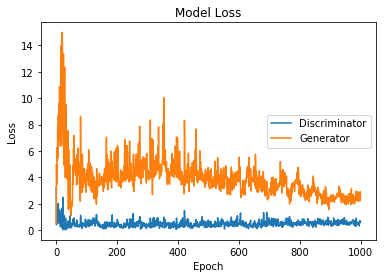

In [0]:
# Plotting model loss

plt.plot(d_loss)
plt.plot(g_loss)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')

plt.show()

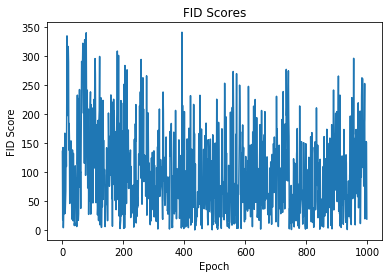

In [0]:
# Plotting FID scores

plt.plot(fid_score[1:])
plt.title('FID Scores')
plt.ylabel('FID Score')
plt.xlabel('Epoch')

plt.show()

# SA-GAN

In [0]:
import tensorflow as tf
from keras.engine.topology import Layer

In [0]:
latent_dim = 100
init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
img_shape = trainX[0].shape
optimizer = Adam(0.0003, 0.5)

## Self-attention layer

In [0]:
def hw_flatten(x):
    
    # Input shape x: [BATCH, HEIGHT, WIDTH, CHANNELS]
    # Return [BATCH, W*H, CHANNELS]
    
    x_shape = tf.shape(x) 
    return tf.reshape(x, [x_shape[0], -1, x_shape[-1]])

In [0]:
class Self_Attention(Layer):
  
  def __init__(self, channel, dtype=tf.float64):
    
    super(Self_Attention, self).__init__()
    
    self.f = Conv2D(channel // 8, 1, strides=1, padding='SAME')
    self.g = Conv2D(channel // 8, 1, strides=1, padding='SAME')
    self.h = Conv2D(channel, 1, strides=1, padding='SAME')
    
    self.gamma = tf.contrib.eager.Variable(0., trainable=True, name="gamma")
    
  def call(self, x):

    f = self.f(x)
    g = self.g(x)
    h = self.h(x)
    
    f_flatten = hw_flatten(f)
    g_flatten = hw_flatten(g)
    h_flatten = hw_flatten(h)
    
    s = tf.matmul(g_flatten, f_flatten, transpose_b=True)

    beta = tf.nn.softmax(s, axis=-1)
    o = tf.matmul(beta, h_flatten)
    o = tf.reshape(o, shape=x.shape)
    y = self.gamma * o + x

    return y

## Wasserstein loss function

In [0]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

## Generator

In [0]:
def build_generator():
  model = Sequential()

  model.add(Dense(2 * 2 * 512, input_dim=latent_dim, activation="relu", 
                  kernel_initializer=init))
  model.add(Reshape((2, 2, 512)))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', 
                            activation='relu', kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  Self_Attention(256)
  
  model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', 
                            activation='relu', kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  Self_Attention(128)
  
  model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', 
                            activation='relu', kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  Self_Attention(64)
  
  model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', 
                            activation='tanh', kernel_initializer=init))
  
  # print("Generator: ")
  # model.summary()
  
  return model

In [0]:
generator_sa = build_generator()

## Discriminator w/ Spectral Normalization

In [0]:
def build_discriminator():
  model = Sequential()
  
  model.add(ConvSN2D(64, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init, input_shape=img_shape))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  Self_Attention(64)
  
  model.add(ConvSN2D(128, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  Self_Attention(128)
  
  model.add(ConvSN2D(256, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  Self_Attention(256)
  
  model.add(ConvSN2D(512, kernel_size=4, strides=2, padding='same', 
                   kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(DenseSN(1, activation='sigmoid', kernel_initializer=init))
  
  # print("Discriminator: ")
  # model.summary()
  
  return model

In [0]:
discriminator_sa = build_discriminator()

## Compile model

In [0]:
# Optimizer

discriminator_sa.compile(optimizer=optimizer, loss=wasserstein_loss,
                        metrics=['accuracy'])

# Only train generator

discriminator_sa.trainable = False
z = Input(shape=(latent_dim,))
img = generator_sa(z)

# The discriminator takes images generated from generator as input and determines validity

validity = discriminator_sa(img)
combined_sa = Model(z, validity)

combined_sa.compile(optimizer=optimizer, loss=wasserstein_loss,
                   metrics=['accuracy'])

## FID score calculation

In [0]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

In [0]:
# Inception v3 model

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    new_image = resize(image, new_shape, 0)
    images_list.append(new_image)
  return asarray(images_list)

# Calculate FID

def calculate_fid(model, images1, images2):
  act1 = model.predict(images1)
  act2 = model.predict(images2)

  # Mean and covariance
  
  u1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  u2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  ssd = np.sum((u1 - u2) * 2.0)
  covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0]

  if iscomplexobj(covmean):
    covmean = covmean.real

  fid = ssd + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

## Train model

In [0]:
epochs = 1000
batch_size = 64
learning_rate = 0.0002

In [0]:
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
testX = (testX / 2 + 0.5) * 255

d_loss_sa = []
g_loss_sa = []
fid_score_sa = []
W_loss = []

for epoch in range(epochs):
  
  # Train discriminator
  
  discriminator_sa.trainable = True
  ids = np.random.randint(0, trainX.shape[0], batch_size)
  imgs = trainX[ids]
  
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
  imgs_gen = generator_sa.predict_on_batch(noise)
  
  discriminator_loss_real = discriminator_sa.train_on_batch(imgs, real)
  discriminator_loss_fake = discriminator_sa.train_on_batch(imgs_gen, fake)
  discriminator_loss = 0.5 * (discriminator_loss_real[0] + discriminator_loss_fake[0])

  # Train generator
  
  discriminator_sa.trainable = False
  generator_loss = combined_sa.train_on_batch(noise, real)
  
  print("Epoch: %d/%d, Discriminator loss: %f, Generator loss: %f" % (epoch + 1, epochs, discriminator_loss, generator_loss[0]))
  
  d_loss_sa.append(discriminator_loss)
  g_loss_sa.append(generator_loss[0])
  
  test_noise = np.random.randn(batch_size, 100)
  
  W_real = combined_sa.evaluate(test_noise, real)
  W_fake = combined_sa.evaluate(test_noise, fake)
  W_total = W_real[0] + W_fake[0]
  
  print('Wasserstein loss: {}'.format(W_total))
  
  W_loss.append(W_total)
  
  samples = 10
  noise = np.random.normal(0, 1, (samples, latent_dim))
  imgs_gen = generator_sa.predict(noise)
  imgs_gen = 0.5 * imgs_gen + 0.5

  fig = plt.figure()
  for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(imgs_gen[i])
      
  fol = './images_generated_sa/'
  if not os.path.exists(fol):
        os.makedirs(fol)
    
  fig.savefig(fol + 'sa_cifar_random_{:05d}.png'.format(epoch))
  plt.close()
  
  # FID calculation
  
  images1 = imgs_gen
  images1 = (images1 / 2 + 0.5) * 255
  images2 = testX[epoch*10:(epoch+1)*10]
  
  # Convert to floating point values and resize to fit Inception V3 model

  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  
  fid = calculate_fid(model, images1, images2)
  print('FID: %.3f' % fid)
  
  fid_score_sa.append(fid)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1/1000, Discriminator loss: 0.221994, Generator loss: 0.019544
64/64 [==============================] - 0s 679us/step
Wasserstein loss: 0.036797838285565376
FID: 299.463
Epoch: 2/1000, Discriminator loss: 0.013281, Generator loss: 0.002790
64/64 [==============================] - 0s 508us/step
Wasserstein loss: 0.03256737347692251
FID: 107.482
Epoch: 3/1000, Discriminator loss: 0.003011, Generator loss: 0.001176
64/64 [==============================] - 0s 507us/step
Wasserstein loss: 0.01654939353466034
FID: 201.665
Epoch: 4/1000, Discriminator loss: 0.001290, Generator loss: 0.000677
64/64 [==============================] - 0s 471us/step
Wasserstein loss: 0.008436133153736591
FID: 167.895
Epoch: 5/1000, Discriminator loss: 0.000821, Generator loss: 0.000457
64/64 [==============================] - 0s 608us/step
Wasserstein loss: 0.005912491586059332
FID: 162.679
Epoch: 6/1000, Discri

## Plot metrics

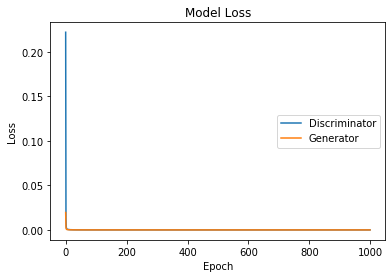

In [0]:
# Plotting model loss

plt.plot(d_loss_sa)
plt.plot(g_loss_sa)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')

plt.show()

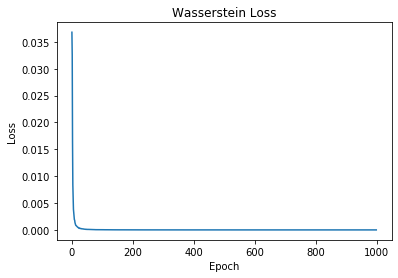

In [0]:
# Plotting wasserstein loss

plt.plot(W_loss)

plt.title('Wasserstein Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

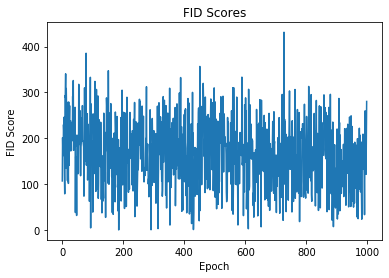

In [0]:
# Plotting FID scores

plt.plot(fid_score_sa[1:])
plt.title('FID Scores')
plt.ylabel('FID Score')
plt.xlabel('Epoch')

plt.show()